## 이미지 준비

현재 컴퓨터에 이미지 파일이 존재할 경우 아래 코드를 수행하지 않고 기본 변수 중 path 변경

In [ ]:
# 이미 다운받은 데이터셋 삭제 (다운받은 데이터셋이 없어도 동작함)
!rm -rf Cifar10.tar.gz
!rm -rf Cifar10/

# 데이터셋 다운로드
!wget -q https://raw.githubusercontent.com/panggin/AI2021_project/main/Cifar10.tar.gz
!tar -xzf Cifar10.tar.gz

!ls

Cifar10  Cifar10.tar.gz  sample_data


## 필요한 라이브러리 호출

In [ ]:
# 라이브러리 호출
import matplotlib.pyplot as plt
import numpy as np

import glob
from skimage.io import imread   # 이미지 불러오기
from skimage.transform import resize   # 이미지 크기 조정
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers, models
from keras.layers import Dense, Dropout, BatchNormalization

import os
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 기본 변수 및 함수 정의

In [ ]:
# 상수 사용을 위함
class Default:
    imgR     = 32
    imgC     = 32
    channel  = 3
    imgCount = 6000
    split    = 5000

In [ ]:
# Label,Data Path Definition
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

path = './Cifar10/' # 분류별 이미지 폴더가 저장된 위치

In [ ]:
# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

##### Dataset load #####
# get image path from each class
def get_image_path_dict(main_path, class_labels):
    paths_dict = {} # 분류별 이미지 경로를 딕셔너리로 저장
    for label in class_labels:
        paths = glob.glob(main_path + class_labels[label] + '/*.jpg')
        paths_dict[label] = np.array(paths)
    print('Done: get image path dictionary') # for debugging
    return paths_dict

# set x, y data of each class
def set_xy_dict(paths_dict, class_labels):
    x_dict, y_dict = {}, {}
    for label in class_labels:
        x_dict[label] = np.array([imread(paths_dict[label][i])
                                    for i in range(Default.imgCount)])
        x_dict[label] = np.array([resize(x_dict[label][i], 
                                        (Default.imgR, Default.imgC, Default.channel)) 
                                    for i in range(Default.imgCount)])
        y_dict[label] = np.full(Default.imgCount, label)
        print(f'{label}: {x_dict[label].shape} {y_dict[label].shape}')
    print('Done: set x, y dictionary') # for debugging
    return x_dict, y_dict

# split train/test data
def split_dict(x_dict, y_dict, class_labels):
    x_dict_train, x_dict_test = {}, {}
    y_dict_train, y_dict_test = {}, {}
    for label in class_labels:
        x_dict_train[label] = x_dict[label][:Default.split]
        x_dict_test[label]  = x_dict[label][Default.split:]
        y_dict_train[label] = y_dict[label][:Default.split]
        y_dict_test[label]  = y_dict[label][Default.split:]
        print(f'train {label}: {x_dict_train[label].shape} {y_dict_train[label].shape}')
        print(f'test {label}: {x_dict_test[label].shape} {y_dict_test[label].shape}')
    print('Done: split x,y dict --> train/test') # for debugging
    return x_dict_train, x_dict_test, y_dict_train, y_dict_test 

# set x, y data - concatenate
def set_xy(x_dict_train, x_dict_test, 
           y_dict_train, y_dict_test, class_labels):
    x_train = np.concatenate([x_dict_train[label] for label in class_labels])
    x_test  = np.concatenate([x_dict_test[label]  for label in class_labels])
    y_train = np.concatenate([y_dict_train[label] for label in class_labels])
    y_test =  np.concatenate([y_dict_test[label]  for label in class_labels])

    # shuffle x, y
    x_train, y_train = shuffle(x_train, y_train)
    x_test,  y_test  = shuffle(x_test, y_test)
    print('Done: set x, y data') # for debugging
    return (x_train, y_train), (x_test, y_test)

# data load
def data_load(path, class_labels):
    paths_dict = get_image_path_dict(path, class_labels)
    x_dict, y_dict = set_xy_dict(paths_dict, class_labels)
    (x_dict_train, x_dict_test, 
     y_dict_train, y_dict_test) = split_dict(x_dict, y_dict, class_labels)
    (x_train, y_train), (x_test, y_test) = set_xy(x_dict_train, x_dict_test,
                                                  y_dict_train, y_dict_test,
                                                  class_labels)
    print('Successfully load data') # for debugging
    return (x_train, y_train), (x_test, y_test)

## 데이터셋 로드

In [ ]:
# 데이터셋 로드
(train_images, train_labels), (test_images, test_labels) = data_load(path, class_labels)

print(f'train data: {train_images.shape} {train_labels.shape}')
print(f'test data: {test_images.shape} {test_labels.shape}')

Done: get image path dictionary
0: (6000, 32, 32, 3) (6000,)
1: (6000, 32, 32, 3) (6000,)
2: (6000, 32, 32, 3) (6000,)
3: (6000, 32, 32, 3) (6000,)
4: (6000, 32, 32, 3) (6000,)
5: (6000, 32, 32, 3) (6000,)
6: (6000, 32, 32, 3) (6000,)
7: (6000, 32, 32, 3) (6000,)
8: (6000, 32, 32, 3) (6000,)
9: (6000, 32, 32, 3) (6000,)
Done: set x, y dictionary
train 0: (5000, 32, 32, 3) (5000,)
test 0: (1000, 32, 32, 3) (1000,)
train 1: (5000, 32, 32, 3) (5000,)
test 1: (1000, 32, 32, 3) (1000,)
train 2: (5000, 32, 32, 3) (5000,)
test 2: (1000, 32, 32, 3) (1000,)
train 3: (5000, 32, 32, 3) (5000,)
test 3: (1000, 32, 32, 3) (1000,)
train 4: (5000, 32, 32, 3) (5000,)
test 4: (1000, 32, 32, 3) (1000,)
train 5: (5000, 32, 32, 3) (5000,)
test 5: (1000, 32, 32, 3) (1000,)
train 6: (5000, 32, 32, 3) (5000,)
test 6: (1000, 32, 32, 3) (1000,)
train 7: (5000, 32, 32, 3) (5000,)
test 7: (1000, 32, 32, 3) (1000,)
train 8: (5000, 32, 32, 3) (5000,)
test 8: (1000, 32, 32, 3) (1000,)
train 9: (5000, 32, 32, 3) (500

[2 1 6 1 7 3 6 6 0 4]
[8 4 6 5 9 3 7 0 0 4]


<Figure size 432x288 with 0 Axes>

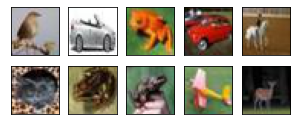

<Figure size 432x288 with 0 Axes>

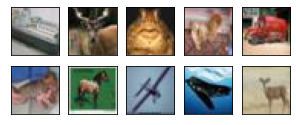

In [ ]:
plot_images(2,5,train_images[:10])
print(train_labels[:10])
plot_images(2,5,test_images[:10])
print(test_labels[:10])

## CNN 모델 생성 및 학습

In [ ]:
# CNN 인공신경망 정의
def create_model():
    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
# 가중치 정보 저장 경로
checkpoint_dir = 'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
model = create_model()
# Checking the model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_164 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_165 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
# !rm -rf Training_checkpoint/ # 가중치 저장 파일 전체 삭제

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=500,
                    callbacks=[early_stopping, cp],
                    validation_split = 0.2, verbose=0)


Epoch 00001: val_loss improved from inf to 3.01132, saving model to cifar10/000_training/cp-0001-3.01.ckpt

Epoch 00002: val_loss improved from 3.01132 to 1.62446, saving model to cifar10/000_training/cp-0002-1.62.ckpt

Epoch 00003: val_loss improved from 1.62446 to 1.30954, saving model to cifar10/000_training/cp-0003-1.31.ckpt

Epoch 00004: val_loss improved from 1.30954 to 1.13179, saving model to cifar10/000_training/cp-0004-1.13.ckpt

Epoch 00005: val_loss improved from 1.13179 to 1.03405, saving model to cifar10/000_training/cp-0005-1.03.ckpt

Epoch 00006: val_loss improved from 1.03405 to 0.94347, saving model to cifar10/000_training/cp-0006-0.94.ckpt

Epoch 00007: val_loss improved from 0.94347 to 0.86161, saving model to cifar10/000_training/cp-0007-0.86.ckpt

Epoch 00008: val_loss improved from 0.86161 to 0.82440, saving model to cifar10/000_training/cp-0008-0.82.ckpt

Epoch 00009: val_loss did not improve from 0.82440

Epoch 00010: val_loss improved from 0.82440 to 0.76303,

## 학습 결과 확인

Text(0.5, 1.0, 'Loss Curves')

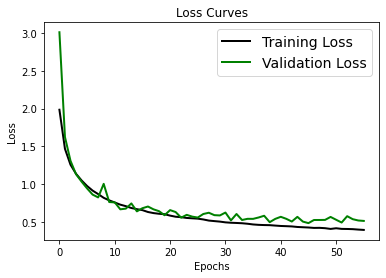

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

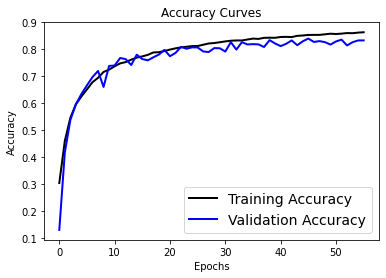

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## 학습한 모델 및 history 정보 파일로 저장

In [ ]:
# 모델 저장
model.save('cifar10/savedModel/')

INFO:tensorflow:Assets written to: cifar10/savedModel/assets


In [ ]:
# history 파일로 저장
history_df = pd.DataFrame(history.history)

with open('cifar10/history.csv', mode='w') as hist_file:
    history_df.to_csv(hist_file)

In [ ]:
##### checkpoint로부터 모델 복원
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = create_model()
model.load_weights(latest)
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 20s - loss: 0.3030 - accuracy: 0.8973 - 20s/epoch - 63ms/step


In [ ]:
##### savedModel에 저장된 모델 복원
model = keras.models.load_model('cifar10/savedModel/')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_164 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_165 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

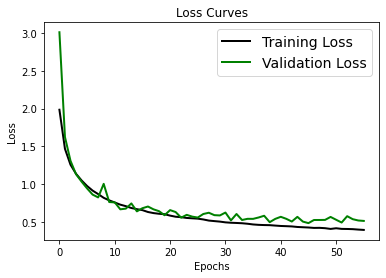

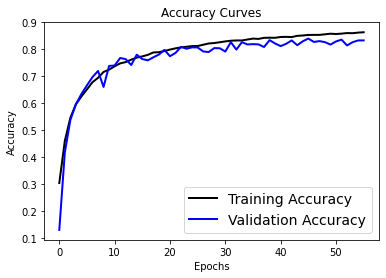

In [ ]:
##### history 파일 로드 --> 그래프 확인
history_df = pd.read_csv('cifar10/history.csv')

# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history_df['loss'], 'black', linewidth=2.0)
plt.plot(history_df['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
plt.show()
plt.close()

# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history_df['accuracy'], 'black', linewidth=2.0)
plt.plot(history_df['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)
plt.show()
plt.close()

## 모델 예측 성능 확인

In [ ]:
np.argmax(model.predict(test_images[0:100]), axis=1)

array([8, 4, 6, 5, 9, 3, 4, 0, 0, 4, 2, 8, 3, 4, 2, 4, 6, 4, 8, 8, 0, 5,
       7, 3, 2, 9, 8, 7, 4, 7, 8, 8, 6, 1, 9, 1, 0, 4, 5, 5, 8, 7, 9, 6,
       1, 1, 2, 5, 0, 3, 2, 9, 0, 3, 4, 2, 3, 5, 8, 7, 7, 5, 9, 1, 5, 7,
       9, 7, 6, 0, 2, 0, 4, 1, 6, 5, 1, 8, 8, 5, 8, 7, 4, 9, 5, 1, 4, 1,
       3, 7, 7, 8, 6, 3, 7, 5, 7, 6, 6, 0])

In [ ]:
pred = model.predict(test_images)
print(pred)
print(pred.shape)

# Converting the predictions into label index 
pred_labels = np.argmax(pred, axis=1)
print(pred_labels)

[[8.1475837e-06 1.6372454e-07 1.2896578e-04 ... 1.7792576e-04
  1.1053589e-05 3.8428734e-06]
 [1.6674405e-03 3.7332320e-05 4.9921684e-03 ... 1.0810441e-04
  8.9227957e-05 2.7710406e-04]
 [5.5045797e-04 1.1152675e-05 3.3990669e-01 ... 5.2811165e-04
  4.9362170e-05 1.2164089e-04]
 ...
 [3.6471534e-05 1.6703419e-06 6.3088536e-04 ... 7.7230132e-01
  2.8163120e-06 2.7078061e-06]
 [3.7712550e-03 5.0671010e-06 9.8829460e-01 ... 3.9528991e-04
  5.2363132e-05 2.0366554e-04]
 [6.8038549e-05 1.2875648e-05 9.7700185e-01 ... 6.9528673e-05
  4.6684770e-05 1.1698684e-05]]
(10000, 10)
[3 3 4 ... 7 2 2]


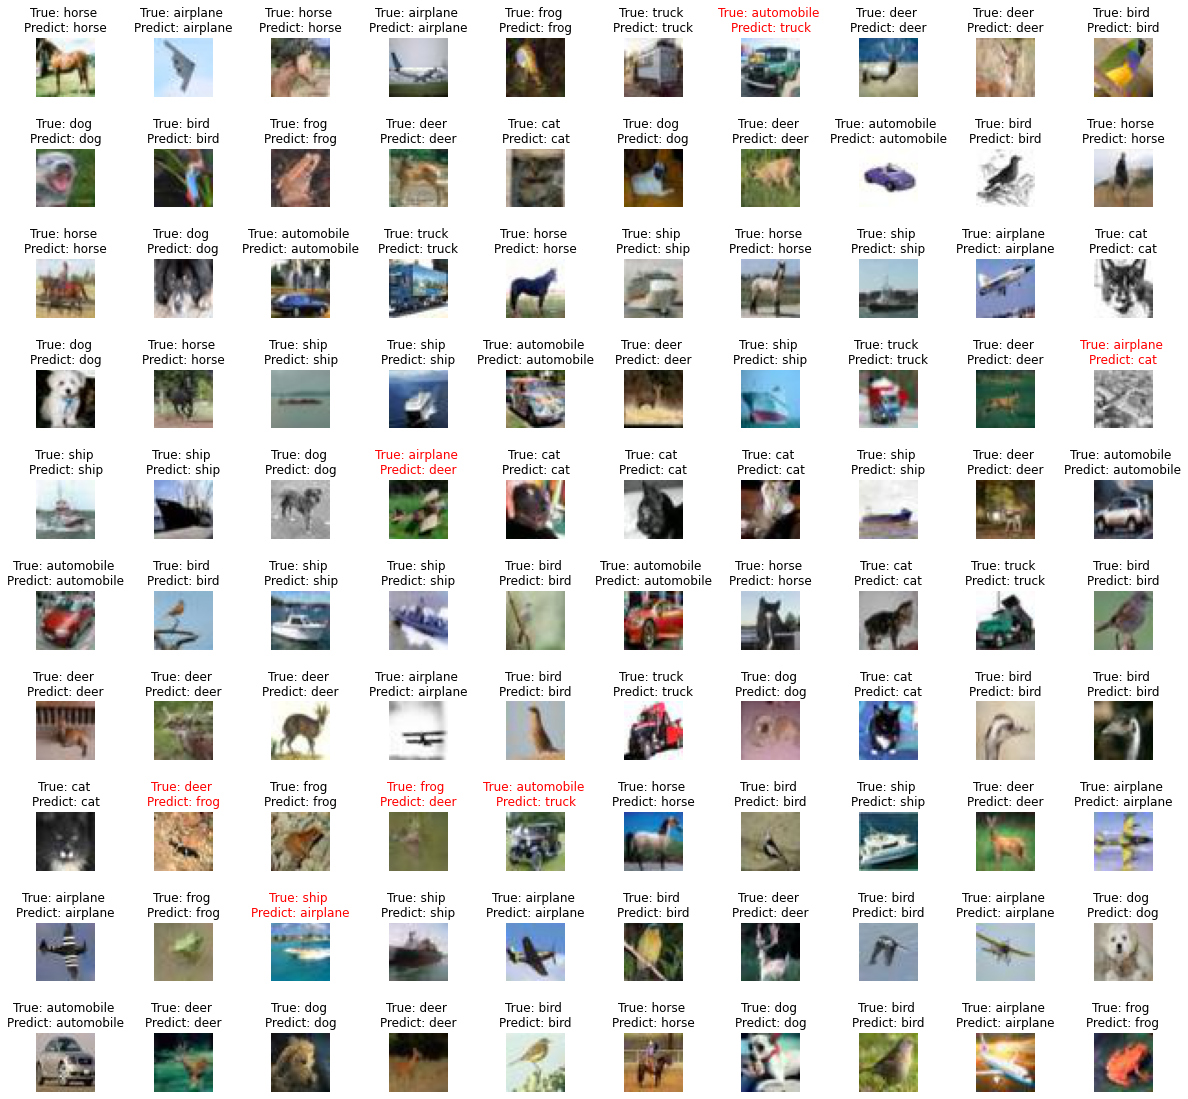

In [ ]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(10, 10, figsize=(20,20))
axes = axes.ravel()

random_idx = np.random.randint(10000, size=100)

for i,idx in enumerate(random_idx):
    axes[i].imshow(test_images[idx])
    true_label, pred_label = class_labels[test_labels[idx]], class_labels[pred_labels[idx]]
    if true_label != pred_label: axes[i].set_title("True: %s \nPredict: %s" % (true_label, pred_label), color='red')
    else : axes[i].set_title("True: %s \nPredict: %s" % (true_label, pred_label))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('테스트 정확도:',test_acc)

313/313 - 20s - loss: 0.2993 - accuracy: 0.9041 - 20s/epoch - 63ms/step
테스트 정확도: 0.9041000008583069


In [ ]:
# 가중치 저장 폴더 압축
!zip Training_checkpoint.zip -r Training_checkpoint/
# 모델 저장된 폴더 압축
!zip Team2_model.zip -r cifar10/

In [ ]:
!tar zcvf Team2_model.tar.gz cifar10/

cifar10/
cifar10/savedModel/
cifar10/savedModel/assets/
cifar10/savedModel/variables/
cifar10/savedModel/variables/variables.data-00000-of-00001
cifar10/savedModel/variables/variables.index
cifar10/savedModel/keras_metadata.pb
cifar10/savedModel/saved_model.pb
cifar10/history.csv
